In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import DataLoader
import numpy as np

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [2]:
import importlib
try: 
    importlib.reload(generators)
    importlib.reload(utils)
    importlib.reload(trainers)
    importlib.reload(u_net)
    print("libs reloaded")
except:
    import generators
    import trainers
    import utils
    import u_net
    print("libs imported")

TrainerUNET = trainers.TrainerUNET

libs imported


# UNET

In [8]:
# directorys with data and to store training checkpoints and logs
WORKING_DIR = Path(r"C:\Users\marti\OneDrive - TU Eindhoven\Documenten\Master\Q3\Capita Selecta\Project")
DATA_DIR = WORKING_DIR / "TrainingData"
PROGRESS_DIR = WORKING_DIR / "progress_unet"
PROGRESS_DIR.mkdir(parents=True, exist_ok=True)
VAEMASK_WEIGHTS = WORKING_DIR / "CapitaSelectaCode" / "Machine learning" / "weights" / "vaemask_200_epochs_16_zdim.pth" 
VAEGAN_WEIGHTS = WORKING_DIR / "CapitaSelectaCode" / "Machine learning" / "weights" / "vaegan_200_epochs_256_zdim_ema.pth" 

# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 3
IMAGE_SIZE = [64, 64]  # images are made smaller to save training time
N = 15
train_size = N-NO_VALIDATION_PATIENTS
seed = 0
N_EPOCHS = 100
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-4
TOLERANCE = 0.001  # for early stopping
DISPLAY_FREQ = 5
Number_of_fake = 32
if Number_of_fake == 32:
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 32 - Number_of_fake
BATCH_SIZE_VALID = 32
EARLY_STOPPING = False
MINIMUM_VALID_LOSS = 10
exp = str(N_EPOCHS) + '_epochs_' + str(Number_of_fake) + "_number_of_fake"
EXPERIMENT_DIR = PROGRESS_DIR / exp
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

utils.remove_empty_masks(DATA_DIR)

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(sorted(patients), random_state=seed, train_size=train_size)

# split in training/validation after shuffling
partition = {
    "train": train_indx,
    "validation": valid_indx,
}

mask_generator = generators.VAE(spade=False).to(device)
mask_generator.load_state_dict(torch.load(VAEMASK_WEIGHTS, map_location=device))
mask_generator.eval()

image_generator = generators.VAEGAN(spade=True).to(device)
image_generator.load_state_dict(torch.load(VAEGAN_WEIGHTS, map_location=device))
image_generator.eval()

# load training data and create DataLoader with batching and shuffling
train_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE_VALID,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

mask_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE, empty_masks=True)
mask_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE_VALID,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )


In [ ]:
unet_model = u_net.UNet(num_classes=1).to(device)
# optimizer = torch.optim.SGD(unet_model.parameters(), lr=LEARNING_RATE, momentum=0.95, nesterov=True, weight_decay=1e-3)
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=LEARNING_RATE, betas=(0.95, 0.999), weight_decay=1e-3)

In [ ]:
u_net_trainer = TrainerUNET(net=unet_model, 
                            optimizer=optimizer, 
                            progress_dir=EXPERIMENT_DIR, 
                            train_loader=train_loader, 
                            valid_loader=valid_loader, 
                            mask_loader=mask_loader,
                            mask_generator=mask_generator,
                            image_generator=image_generator,
                            TOLERANCE = TOLERANCE,
                            minimum_valid_loss = MINIMUM_VALID_LOSS,
                            Number_of_fake = Number_of_fake,
                            CHECKPOINTS_DIR=EXPERIMENT_DIR, 
                            device=device,
                            early_stopping=False) 

In [ ]:
u_net_trainer.train(N_EPOCHS, 1, lambda_lr=lambda_lr)

  0%|          | 0/51 [00:00<?, ?it/s]

/Users/ivannovikov/Documents/Study/CSMIA/CapitaSelectaCode-main/Machine learning/upsample.py:16: UserWarning: MPS: The constant padding of more than 3 dimensions is not currently supported natively. It uses View Ops default implementation to run. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Pad.mm:393.)
  out = F.pad(out, [0, 0, 0, up_x - 1, 0, 0, 0, up_y - 1])
/opt/homebrew/anaconda3/envs/medim/lib/python3.8/site-packages/torch/nn/functional.py:3958: UserWarning: The operator 'aten::_upsample_bilinear2d_aa.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn._upsample_bilinear2d_aa(input, output_size, align_corners, scale_factors)


best valid loss = 0.36021143198013306


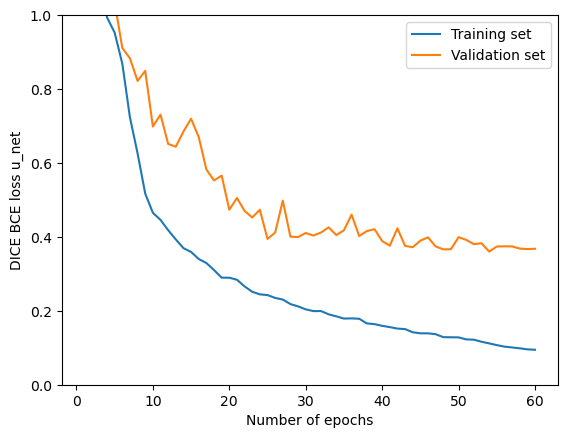

In [ ]:
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.train_losses[0])
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.valid_losses[0])
plt.xlabel('Number of epochs')
plt.ylabel('DICE BCE loss u_net')
plt.ylim([0, 1])
plt.legend(['Training set', 'Validation set'])
plot_name = 'DICE_BCE_LOSS_'+ str(N_EPOCHS) + '_epochs_' + str(Number_of_fake) + "_number_of_fake.png"
path = EXPERIMENT_DIR / plot_name

print(f"best valid loss = {min(u_net_trainer.valid_losses[0])}")
np.savetxt(EXPERIMENT_DIR / "results_train.csv", u_net_trainer.train_losses[0], delimiter=",")
np.savetxt(EXPERIMENT_DIR / "results_valid.csv", u_net_trainer.valid_losses[0], delimiter=",")
plt.savefig(path, dpi=200)